<a href="https://colab.research.google.com/github/Jundo22l/CAU_internship/blob/main/FCN_VOC.ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import os
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import PolynomialLR
from torch.cuda.amp import GradScaler, autocast

# VOC 데이터셋 다운로드 및 준비
root_dir = './'
voc_dataset = datasets.VOCSegmentation(root=root_dir, year='2012', image_set='train', download=True)

# Custom Dataset 클래스 정의
class VOCDataset(Dataset):
    def __init__(self, root, image_set='train', transform=None, target_transform=None):
        self.root = root
        self.image_set = image_set
        self.transform = transform
        self.target_transform = target_transform
        voc_root = os.path.join(self.root, 'VOCdevkit/VOC2012')
        self.image_dir = os.path.join(voc_root, 'JPEGImages')
        self.mask_dir = os.path.join(voc_root, 'SegmentationClass')
        self.image_sets_file = os.path.join(voc_root, 'ImageSets/Segmentation', f'{self.image_set}.txt')

        # 이미지와 마스크 파일 경로 리스트 생성
        with open(self.image_sets_file, "r") as f:
            file_names = f.read().splitlines()

        self.image_names = [os.path.join(self.image_dir, x + ".jpg") for x in file_names]
        self.mask_names = [os.path.join(self.mask_dir, x + ".png") for x in file_names]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img = Image.open(self.image_names[idx]).convert('RGB')
        mask = Image.open(self.mask_names[idx])

        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            mask = self.target_transform(mask)

        mask = np.array(mask)
        mask = torch.from_numpy(mask).long()

        return img, mask

# 데이터 변환 설정
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
])

# 학습 및 검증 데이터셋과 데이터로더 생성
train_dataset = VOCDataset(root='./', image_set='train', transform=transform, target_transform=target_transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)

val_dataset = VOCDataset(root='./', image_set='val', transform=transform, target_transform=target_transform)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

100%|██████████| 1999639040/1999639040 [00:47<00:00, 42456844.42it/s]


Extracting ./VOCtrainval_11-May-2012.tar to ./


In [2]:
# 모델 정의 (ResNet50 기반 FCN)
class FCN_ResNet50(nn.Module):
    def __init__(self, n_class):
        super(FCN_ResNet50, self).__init__()
        self.n_class = n_class

        # Pretrained ResNet50 모델을 인코더로 사용
        resnet = models.resnet50(pretrained=True)
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1  # ResNet의 conv2_x
        self.layer2 = resnet.layer2  # ResNet의 conv3_x
        self.layer3 = resnet.layer3  # ResNet의 conv4_x
        self.layer4 = resnet.layer4  # ResNet의 conv5_x

        # 디코더 부분
        self.fc6 = nn.Conv2d(2048, 4096, kernel_size=1)
        self.fc7 = nn.Conv2d(4096, 4096, kernel_size=1)
        self.score_fr = nn.Conv2d(4096, n_class, kernel_size=1)

        # 스킵 연결을 위한 1x1 convolution layers
        self.score_layer4 = nn.Conv2d(1024, n_class, kernel_size=1)
        self.score_layer3 = nn.Conv2d(512, n_class, kernel_size=1)

    def forward(self, x):
        input_size = x.size()[2:]

        # Encoder (ResNet50)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        layer3 = self.layer2(x)
        layer4 = self.layer3(layer3)
        x = self.layer4(layer4)

        # Decoder
        x = F.relu(self.fc6(x))
        x = F.dropout(x, 0.5)
        x = F.relu(self.fc7(x))
        x = F.dropout(x, 0.5)
        x = self.score_fr(x)

        x = F.interpolate(x, layer4.size()[2:], mode='bilinear', align_corners=True)
        score_layer4 = self.score_layer4(layer4)
        x += score_layer4

        x = F.interpolate(x, layer3.size()[2:], mode='bilinear', align_corners=True)
        score_layer3 = self.score_layer3(layer3)
        x += score_layer3

        x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=True)

        return x

In [4]:
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# FCN-ResNet50 모델 생성 및 설정
model = FCN_ResNet50(n_class=21).to(device)

# 손실 함수 설정
criterion = nn.CrossEntropyLoss(ignore_index=255)

# 옵티마이저 설정 (SGD로 변경)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

# 학습률 스케줄러 설정
num_epochs = 20
iters_per_epoch = len(train_loader)
main_lr_scheduler = PolynomialLR(
    optimizer, total_iters=iters_per_epoch * num_epochs, power=0.9
)

# 혼합 정밀도 학습을 위한 GradScaler 초기화
scaler = GradScaler()

<ipython-input-4-09db49746e80>:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [5]:
# IOU 계산 함수
def compute_iou(outputs, labels, n_class=21):
    outputs = torch.argmax(outputs, dim=1)  # 예측된 클래스
    iou_list = []
    for cls in range(n_class):
        pred_inds = (outputs == cls)
        target_inds = (labels == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()

        if union == 0:
            iou_list.append(float('nan'))  # 이 클래스는 데이터에 없음
        else:
            iou_list.append(intersection / union)

    return iou_list

# IOU 계산을 위한 변수 초기화
train_ious = []
val_ious = []

# 학습 루프
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_iou = []
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # 혼합 정밀도 학습 적용
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        # IOU 계산
        iou = compute_iou(outputs, labels)
        running_iou.extend(iou)

    main_lr_scheduler.step()
    train_loss = running_loss / len(train_loader)
    train_iou = np.nanmean(running_iou)  # NaN 값을 제외하고 IOU 평균 계산
    train_losses.append(train_loss)
    train_ious.append(train_iou)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss}, IOU: {train_iou}")

    # 검증 루프
    model.eval()
    val_loss = 0.0
    val_iou = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # IOU 계산
            iou = compute_iou(outputs, labels)
            val_iou.extend(iou)

    val_loss = val_loss / len(val_loader)
    val_iou = np.nanmean(val_iou)  # NaN 값을 제외하고 IOU 평균 계산
    val_losses.append(val_loss)
    val_ious.append(val_iou)
    print(f"Validation Loss: {val_loss}, Validation IOU: {val_iou}")

<ipython-input-5-fe6839194ea4>:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/20, Loss: 1.0412430141141507, IOU: 0.10409047018431881
Validation Loss: 0.7473488497537571, Validation IOU: 0.1421335187736938
Epoch 2/20, Loss: 0.6136866228990867, IOU: 0.20236421291146936
Validation Loss: 0.5218804707893958, Validation IOU: 0.2528841811141702
Epoch 3/20, Loss: 0.42196893504734245, IOU: 0.29678462663868577
Validation Loss: 0.4604521874379326, Validation IOU: 0.29734480917895384
Epoch 4/20, Loss: 0.3309791242815758, IOU: 0.3458771827555672
Validation Loss: 0.5258227035730749, Validation IOU: 0.27950394726012606
Epoch 5/20, Loss: 0.24621212918087432, IOU: 0.40637063381254623
Validation Loss: 0.403540821234276, Validation IOU: 0.33553671759594245
Epoch 6/20, Loss: 0.18416703549402008, IOU: 0.4646616481895775
Validation Loss: 0.4586483889801817, Validation IOU: 0.34568967887816276
Epoch 7/20, Loss: 0.15094828194444948, IOU: 0.501085858035089
Validation Loss: 0.42890534177422523, Validation IOU: 0.33678243689344645
Epoch 8/20, Loss: 0.1262890594538118, IOU: 0.53793

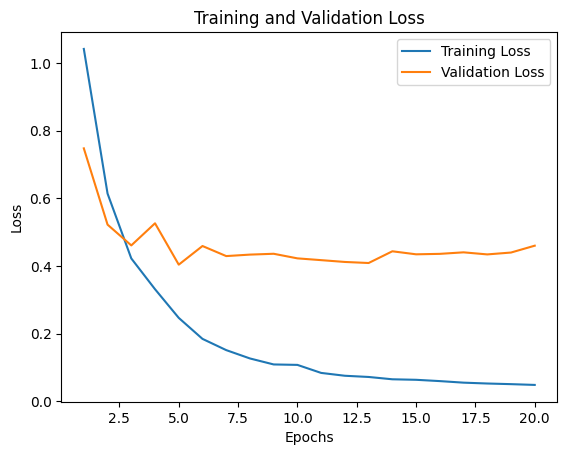

In [6]:
# 시각화 함수
def visualize_segmentation(original_image, input_image, output_mask):
    original_image = np.array(original_image)
    input_image = input_image.cpu().numpy().transpose(1, 2, 0)
    output_mask = output_mask.cpu().numpy()

    palette = np.array([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = np.array([i for i in range(21)])[:, None] * palette
    colors = (colors % 255).astype("uint8")

    output_image = Image.fromarray(output_mask.astype(np.uint8))
    output_image.putpalette(colors.flatten())
    output_image = output_image.convert("RGB")

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(original_image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(input_image)
    ax[1].set_title("Input Image")
    ax[1].axis("off")

    ax[2].imshow(output_image)
    ax[2].set_title("Segmented Output")
    ax[2].axis("off")

    plt.show()

# 학습 및 검증 손실 시각화
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

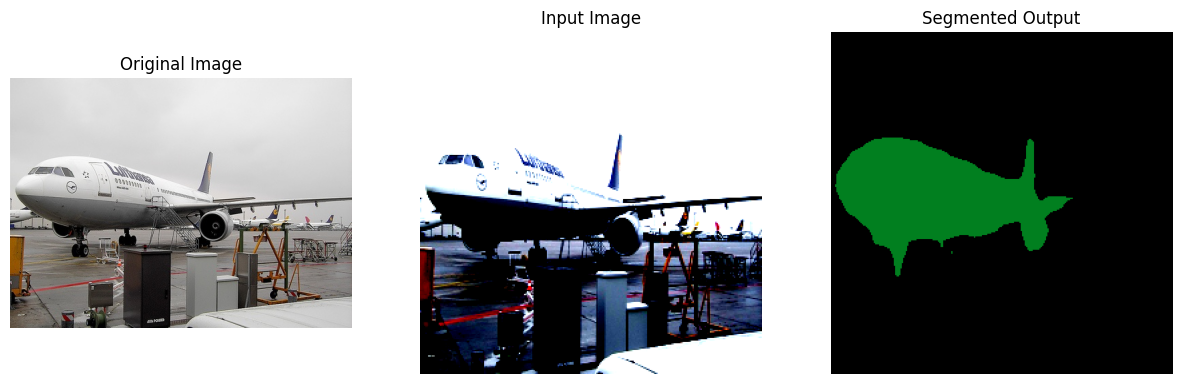

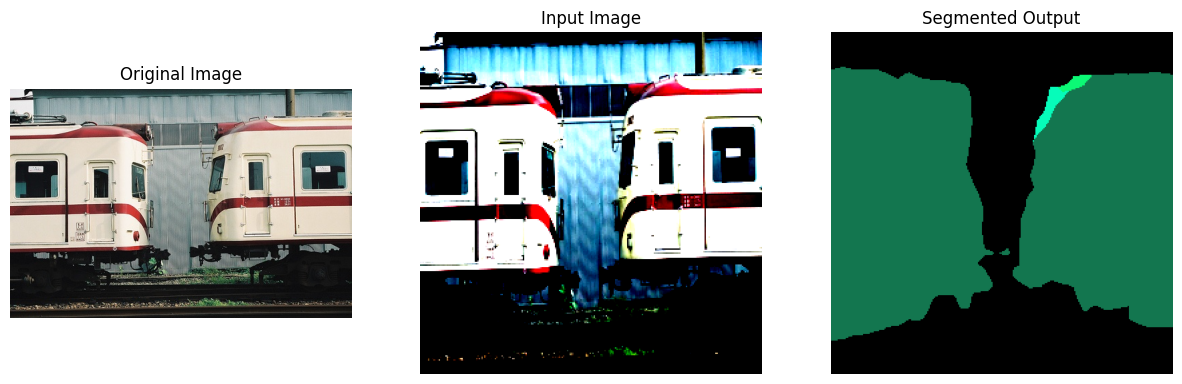

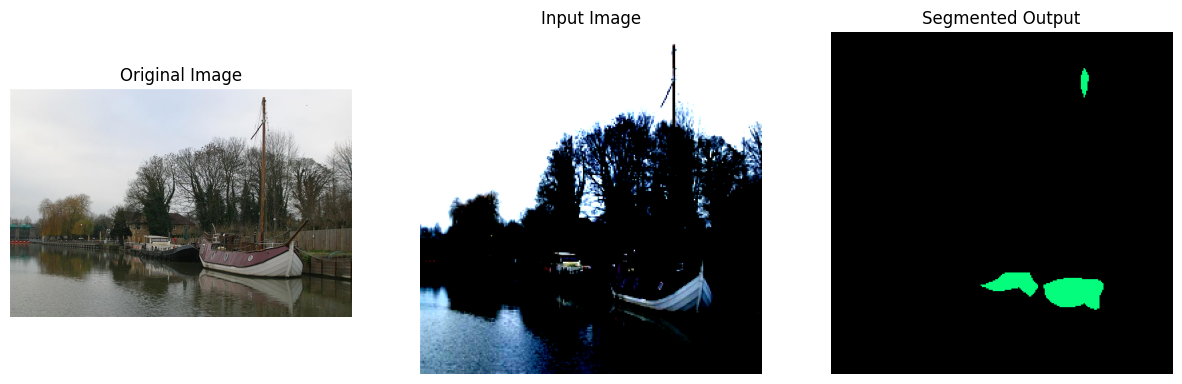

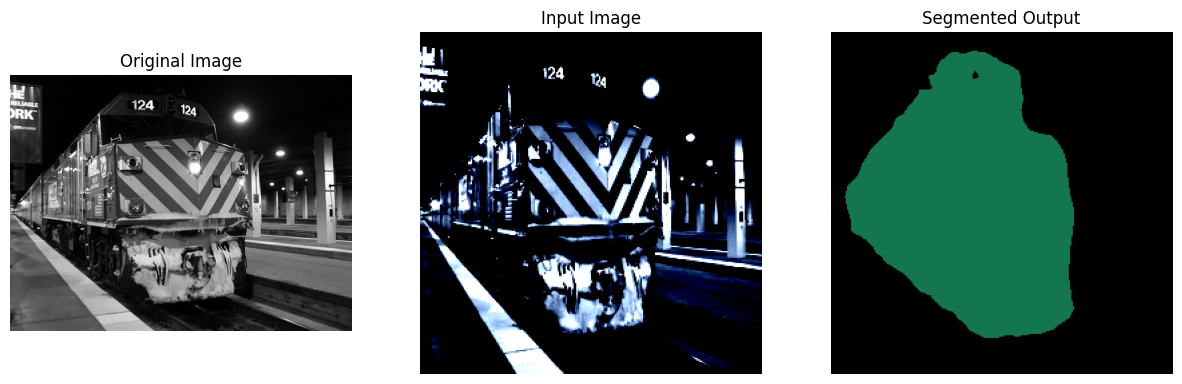

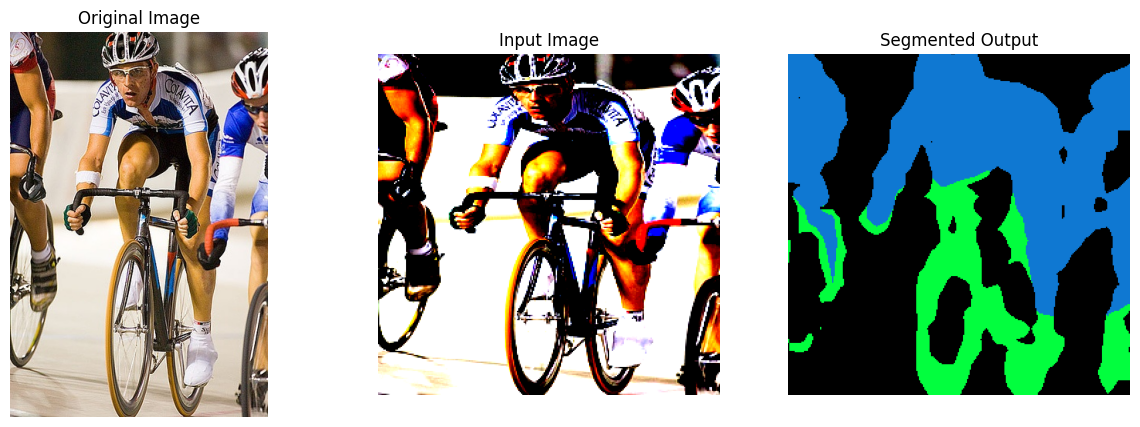

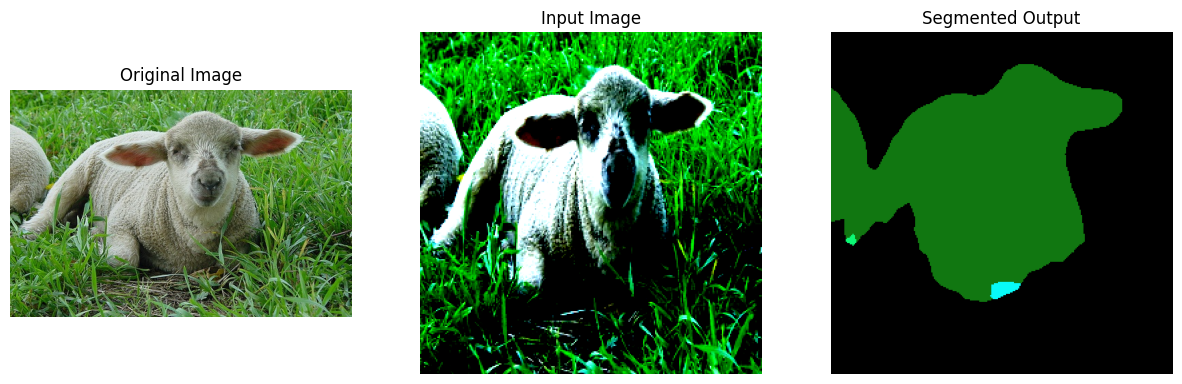

In [8]:
# 테스트 및 시각화
model.eval()
test_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        original_image = Image.open(val_dataset.image_names[i]).convert('RGB')

        inputs = inputs.to(device)
        outputs = model(inputs)
        output_predictions = outputs.argmax(1)

        visualize_segmentation(original_image, inputs[0], output_predictions[0])

        if i >= 5:
            break